In [12]:
# Imports
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from csv import reader

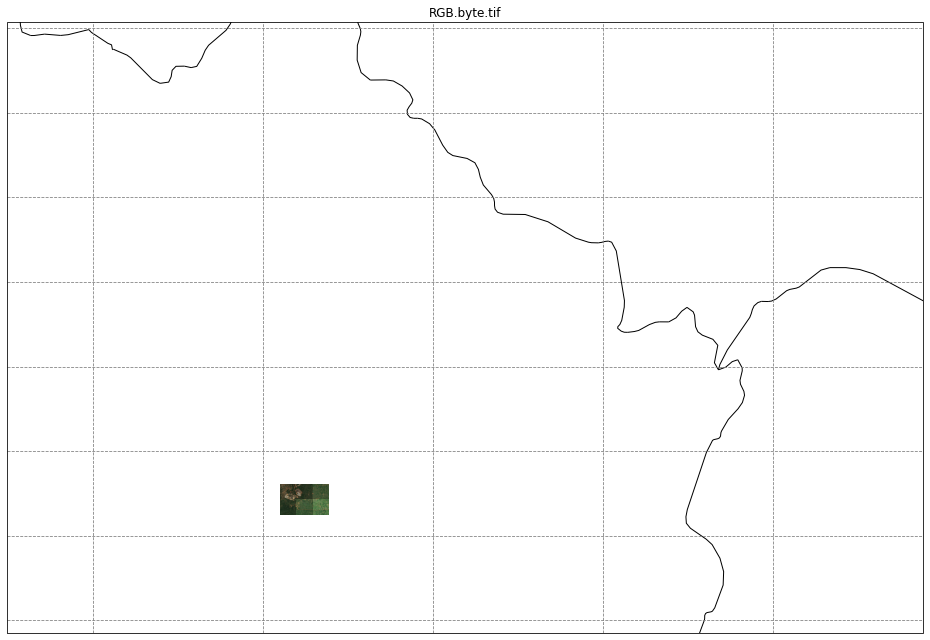

In [11]:
geod = ccrs.Geodetic()
# Google earth engine uses Mercator while S2 uses UTM, both look accurate, but Mercator is easier to use because of the zone restrictions in UTM
proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0, globe=None, latitude_true_scale=0.0)
plt.figure(figsize=(16,9))
# Entire eastern half of DRC - Mercator
#ease_extent = [2500000., 3500000., -1500000., 600000.]
# Zoomed in - Mercator
ease_extent = [3200000., 3500000., 300000., 500000.]

# Set projection and boundaries
ax = plt.axes(projection=proj)
ax.set_extent(ease_extent, crs=proj)

# Create a list of all the Geotiffs corresponding to rows in the give CSV file (file_name)
def images_prep(file_name):
    image_list = []
    with open(file_name, 'r') as read_obj:
        csv_reader = reader(read_obj)
        # Skip Header
        header = next(csv_reader)
        if header != None:
        # Iterate over each row after the header in the csv
            for row in csv_reader:
                tiff = rasterio.open('/scratch/nason.e/gee/region_geotiffs/region_'+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+'.tif')
                b = tiff.bounds
                im = tiff.read()
                im = np.transpose(im, [1,2,0])
                maxValue = np.amax(im)
                im = im/np.amax(im)
                im = np.clip(im, 0, 1)
                image_list.append((im, b))
    return image_list

# Get the bounds for a given image
def image_bounds(im_single):
    xul, yul = proj.transform_point(
        x = im_single[0],
        y = im_single[1],
        src_crs = geod)
    xlr, ylr = proj.transform_point(
        x = im_single[2],
        y = im_single[3],
        src_crs = geod)
    extent = [xul, xlr, yul, ylr]
    return extent

# File: results_csv/all_regions.csv
# Or, for passing regions only, results_csv/all_regions_passing.csv
images = images_prep('results_csv/all_regions.csv')

# Map each image in the list onto the projection
for image, b in images:
    ax.imshow(image, extent=image_bounds(b), transform=proj, origin='upper')

# Set gridlines, country borders, coastlines, title
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.title('RGB.byte.tif')
# Clip images to fit projected region
plt.tight_layout()